In this task, we are charged with implementing a classical algorithm (MCMC algorithm based on thermal fluctuations) to solve the NP hard problem of determining the max independent set out of the nodes of a given 6 node graph. 

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import abc
from shapely.geometry import Polygon
import time
import networkx as nx
from collections import Counter
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,8)

Here we have added an additional component to the MCMC algorithm by adding a Wolff condition (the Wolff condition, as opposed to the Metropolis Hastings condition; flips the spins of multiple vertices of the graph). We test how this new Wolff implementation fairs compared to the given Metroplis-Hastings implementation. 

In [2]:
class AbstractUDMIS(abc.ABC):
    @abc.abstractmethod
    def energy(self):
        """Returns the energy of the current Rydberg occupation configuration"""

    @abc.abstractmethod
    def energy_diff(self, *coords):
        """Returns the energy difference resulting from flipping the occupation at the given coordinates"""
        
    @abc.abstractmethod
    def rand_vertex(self):
        """Selects a site in the graph at random"""
    
    def mc_step(self, T):
        """Performs a full update of the Rydberg model using the Metropolis-Hastings algorithm"""
        current_energy = self.energy()
        for _ in range(self.num_vertices):
            vertex = self.rand_vertex()
            dE = self.energy_diff(vertex)
            
            if (dE < 0) or (np.random.rand() < np.exp(-dE / T)):
                current_energy += dE
                self.occupations[vertex] ^= 1 
                # flips occupation 0 --> 1 OR 1 --> 0

        return current_energy
    
    
    
    def mc_step_wolf(self, T):
        """Performs a full update of the Rydberg model using the Metropolis-Hastings algorithm"""
        current_energy = self.energy()
        for _ in range(self.num_vertices):
            vertex = self.rand_vertex()
            vertex2 = vertex - 2
            dE = self.energy_diff(vertex)

            if (dE < 0) or (np.random.rand() < np.exp(-dE / T)):
                current_energy += dE
                self.occupations[vertex] ^= 1 
                if (vertex > 2):
                    if (self.occupations[vertex] == 1) & ((self.occupations[vertex2] == 0)):
                        self.occupations[vertex2] == 1 
                    elif (self.occupations[vertex] == 0) & ((self.occupations[vertex2] == 1)):
                        self.occupations[vertex2] == 0

                # flips occupation 0 --> 1 OR 1 --> 0

        return current_energy

In [3]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)  

In [4]:
u = 2

graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)

6


Here we have helped speed up the MCMC algorithm by implementing a condition that stops the algorithm if the same three energy levels have been reach in a row. This has vastly improved the algorithm, usually it may iterate 700-800 times, it now requires only 500 interations (for N = 1000) to converge to the ground state. We have also tested changing the initial temperature T_i, and found that as we decrease T_i, the algorithm converges faster.


We notice that as we increase T_i, the algorithm explores the solution space more evenly (i.e reaching higher energy levels) as we might expect, since the thermal fluctuations are larger at a higher temperature. 

In [101]:
def iterate(n,T):
    N = n
    t = np.arange(N+1)
    T_i = T
    T_f = 0.001

    T = T_i * ((T_f/T_i) ** (t/N))

    E_list = []
    oc = []

    iterate_max = 0

    for t in range(N):
        # take a look at the abstract_udmis.py file to see how mc_step works
        temp = T[t]
        udmis.find_edges()
        v = udmis.occupations.copy()
        oc.append(v)

        E_list.append(udmis.mc_step(T=temp))

        if t > N*0.1:
            iterate_max = t
            if t % 100 == 0:
                pass
                #print(t, E_list[t], udmis.occupations)
                #iterate_max = t

                if (E_list[t] == E_list[t-1])&(E_list[t-1] == E_list[t-2])&(E_list[t] <= min(E_list)):
                    #print(E_list)
                    break
                    
    return E_list, oc, iterate_max

In [129]:
N = [1000, 10000, 100000]

soln = []

for n in N:
    E_list, oc, iterate_max = iterate(n,100)
    soln.append((E_list, oc, iterate_max))

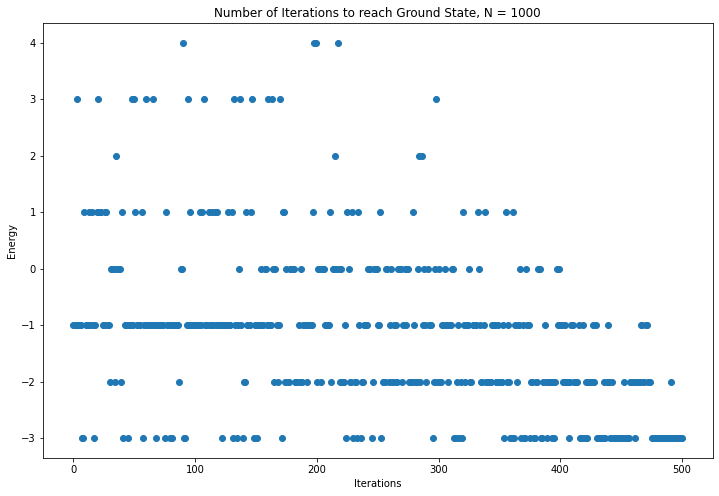

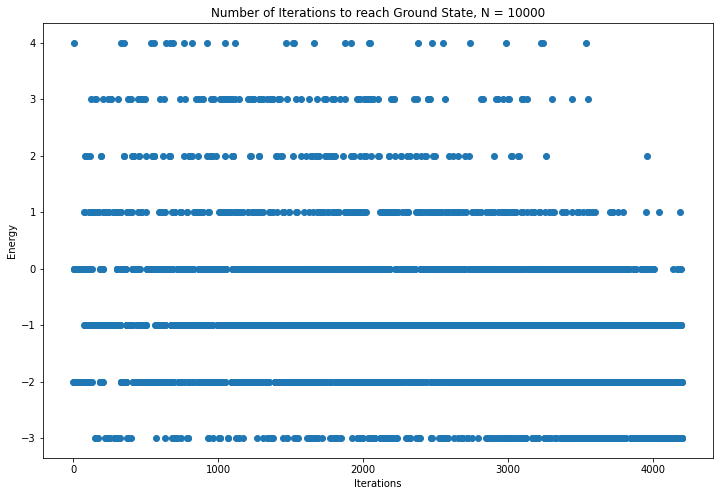

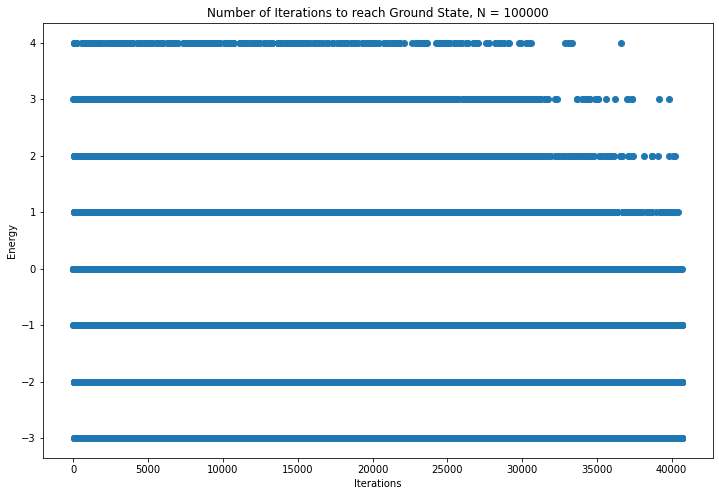

In [130]:
for i in range(len(N)):
    n = N[i]
    plt.scatter(range(soln[i][2] + 1),soln[i][0])
    plt.title(f'Number of Iterations to reach Ground State, N = {n}')
    plt.xlabel('Iterations')
    plt.ylabel('Energy')
    plt.show()

In [131]:
N = [1000, 10000, 100000]

soln = []

for n in N:
    E_list, oc, iterate_max = iterate(n,10000)
    soln.append((E_list, oc, iterate_max))

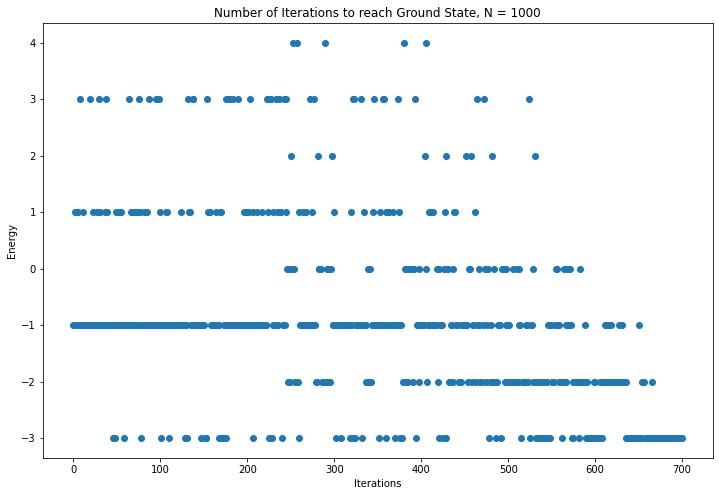

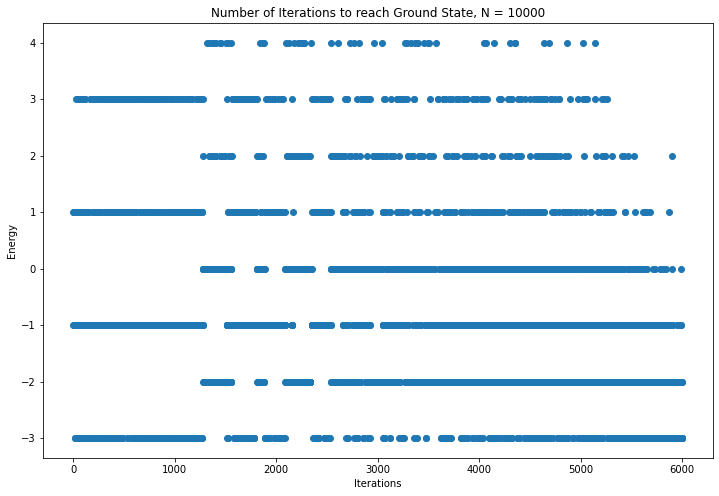

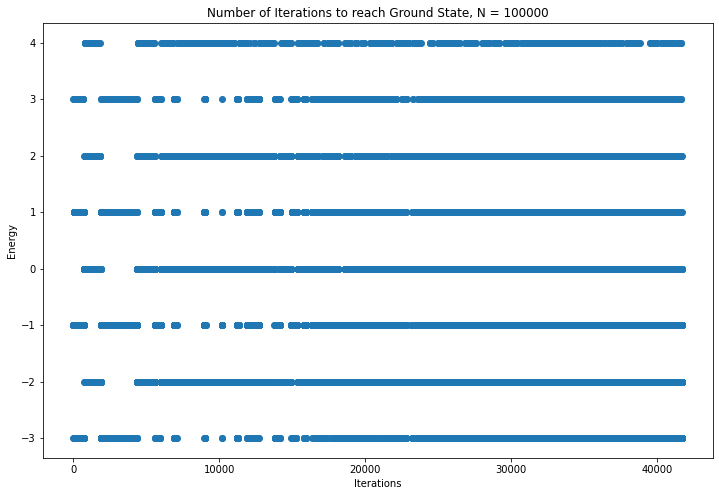

In [132]:
for i in range(len(N)):
    n = N[i]
    plt.scatter(range(soln[i][2] + 1),soln[i][0])
    plt.title(f'Number of Iterations to reach Ground State, N = {n}')
    plt.xlabel('Iterations')
    plt.ylabel('Energy')
    plt.show()

Most common state: [((0, 0, 1, 0, 1, 1), 82), ((0, 0, 1, 1, 1, 0), 29), ((0, 1, 0, 0, 0, 0), 21)]


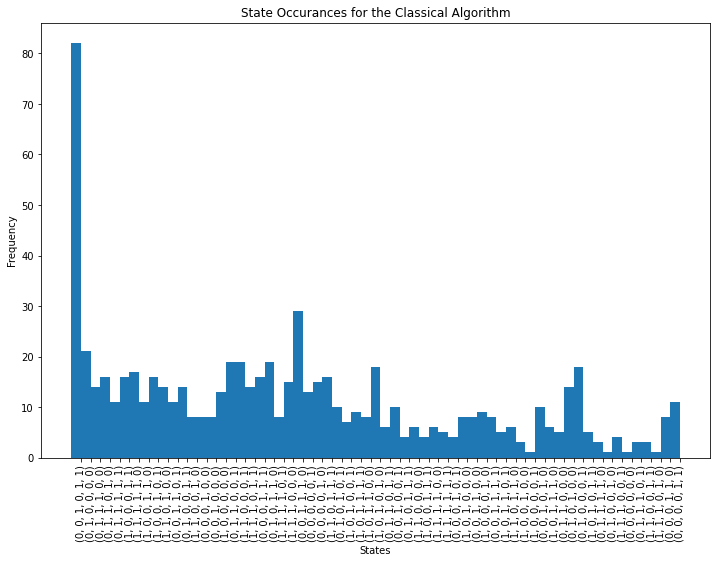

Most common state: [((0, 0, 1, 0, 1, 1), 193), ((0, 0, 1, 1, 1, 0), 171), ((1, 0, 1, 0, 1, 0), 165)]


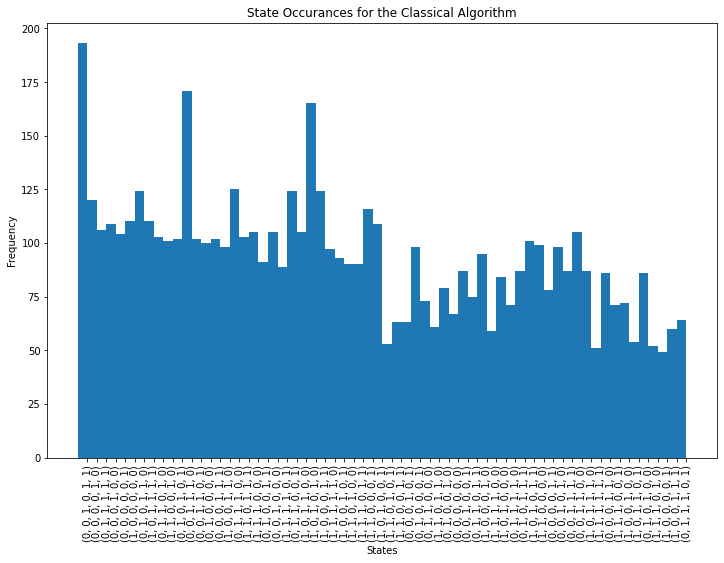

Most common state: [((0, 0, 0, 1, 1, 0), 795), ((1, 0, 1, 0, 0, 0), 791), ((0, 0, 1, 0, 0, 1), 783)]


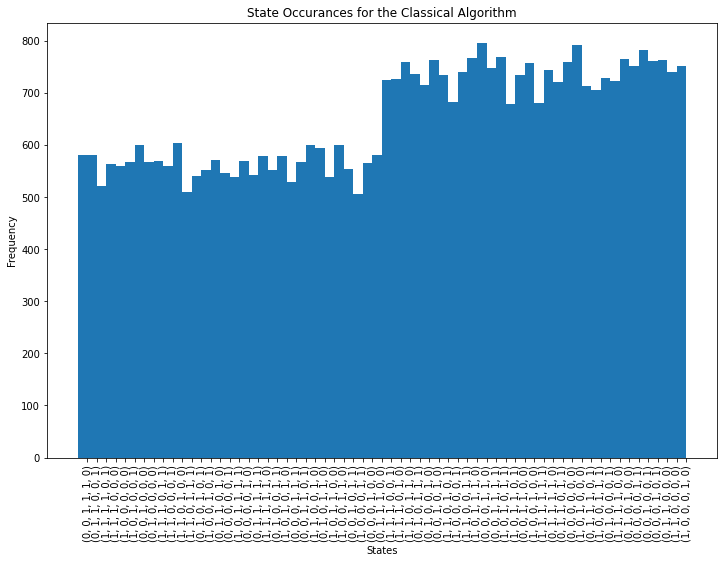

In [133]:
for j in range(len(N)):
    oc_states = []
    for i in soln[j][1]:
        x = [int(val) for val in i]
        oc_states.append(x)

    oc_states_count = map(tuple, oc_states)
    final_count = Counter(oc_states_count)

    labels, values = zip(*final_count.items())

    indexes = np.arange(len(labels))
    width = 1
    
    print('Most common state: ' + str(final_count.most_common(3)))
    
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.title('State Occurances for the Classical Algorithm')
    plt.xlabel('States')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

The Wolff implementation takes a few more iterations to converge; but the same ground states are reached by the two algorithms (the is much more degeneracy in the classical algorithm compared to the quantum implementation). 

In [188]:
N = 10000
t = np.arange(N+1)
T_i = 10000
T_f = 0.001

T = T_i * ((T_f/T_i) ** (t/N))

E_list2 = []
oc = []
t_max = 0
for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    udmis.find_edges()
    v = udmis.occupations.copy()
    oc.append(v)
    
    E_list2.append(udmis.mc_step_wolf(T=temp))

    if t > N*0.1:
        t_max = t
        if t % 100 == 0:
            #print(t, E_list2[t], udmis.occupations)
            pass
            
            if (E_list2[t] == E_list2[t-1])&(E_list2[t-1] == E_list2[t-2])&(E_list2[t] <= min(E_list2)):
                #print(E_list)
                break
print(t_max)   

5900


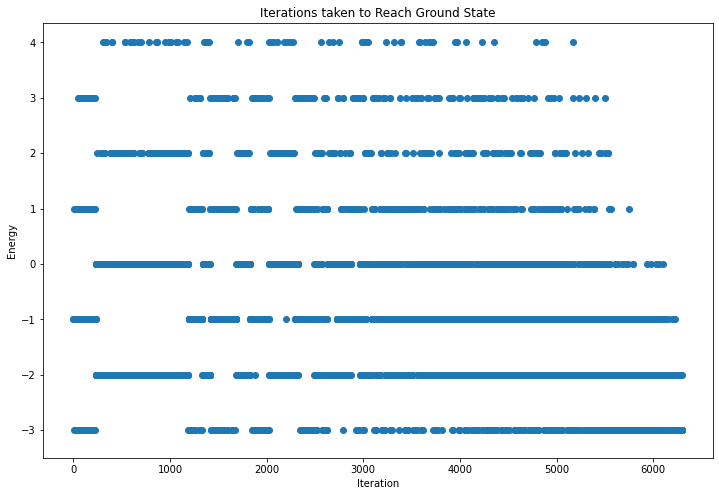

In [167]:
plt.scatter([i for i in range(len(E_list2))], E_list2)
plt.ylim(-3.5)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title("Iterations taken to Reach Ground State");

Most common state: [((0, 0, 1, 0, 1, 1), 1214), ((0, 0, 1, 1, 1, 0), 1167), ((0, 0, 0, 1, 1, 0), 1160)]


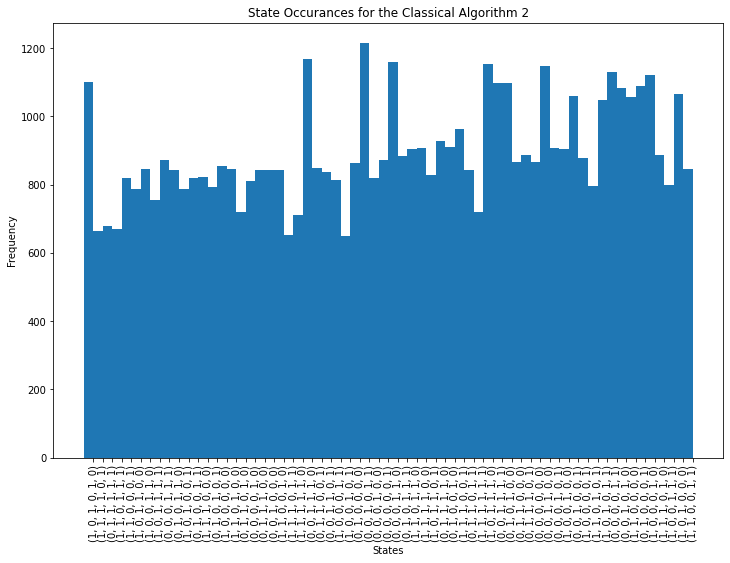

In [136]:
oc_states = []
for i in oc:
    x = [int(val) for val in i]
    oc_states.append(x)

oc_states_count = map(tuple, oc_states)
final_count = Counter(oc_states_count)

labels, values = zip(*final_count.items())

indexes = np.arange(len(labels))
width = 1

print('Most common states: ' + str(final_count.most_common(3)))

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.title('State Occurances for the Classical Algorithm 2')
plt.xlabel('States')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

Experimenting with 2 different annealing schedules

In [197]:
N = 10000
t = np.arange(N+1)
T_i = 10000
T_f = 0.001

T = np.exp(T_i-T_f)*(t/N)

E_list2 = []
oc = []
t_max = 0
for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    udmis.find_edges()
    v = udmis.occupations.copy()
    oc.append(v)
    
    E_list2.append(udmis.mc_step_wolf(T=temp))

    if t > N*0.1:
        t_max = t
        if t % 100 == 0:
            #print(t, E_list2[t], udmis.occupations)
            pass
            
            if (E_list2[t] == E_list2[t-1])&(E_list2[t-1] == E_list2[t-2])&(E_list2[t] <= min(E_list2)):
                #print(E_list)
                break
                
print(t_max)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


4000


In [201]:
N = 10000
t = np.arange(N+1)
T_i = 10000
T_f = 0.001

T = N*np.log(t*abs(T_f-T_i))

E_list2 = []
oc = []
t_max = 0
for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    udmis.find_edges()
    v = udmis.occupations.copy()
    oc.append(v)
    
    E_list2.append(udmis.mc_step_wolf(T=temp))

    if t > N*0.1:
        t_max = t
        if t % 100 == 0:
            #print(t, E_list2[t], udmis.occupations)
            pass
            
            if (E_list2[t] == E_list2[t-1])&(E_list2[t-1] == E_list2[t-2])&(E_list2[t] <= min(E_list2)):
                #print(E_list)
                break
print(t_max)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


1200


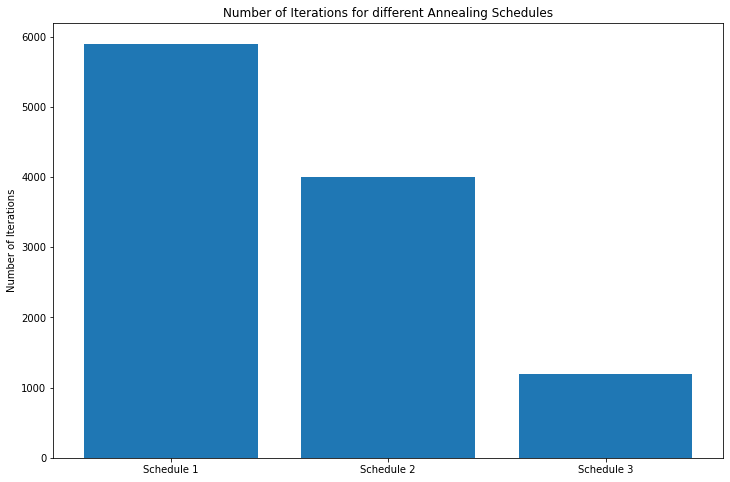

In [204]:
plt.bar(
    x=['Schedule 1', 'Schedule 2', 'Schedule 3'],
    height=[5900, 4000, 1200]
)

plt.title('Number of Iterations for different Annealing Schedules')
plt.ylabel('Number of Iterations');

A picture of the fully connected 6 node graph. 

In [140]:
def get_edges(graph):
    Nv = len(graph)
    edges = np.zeros((Nv, Nv))
    for i in range(Nv - 1):
        xi, yi = graph[i]
        for j in range(i + 1, Nv):
            xj, yj = graph[j]
            dij = np.sqrt((xi - xj) ** 2. + (yi - yj) ** 2.)
            if dij:
                edges[i, j] = 1
    return np.argwhere(edges > 0)

In [141]:
edges = get_edges(graph)
G = nx.Graph()
for edge in edges:
    G.add_edge(edge[0], edge[1])

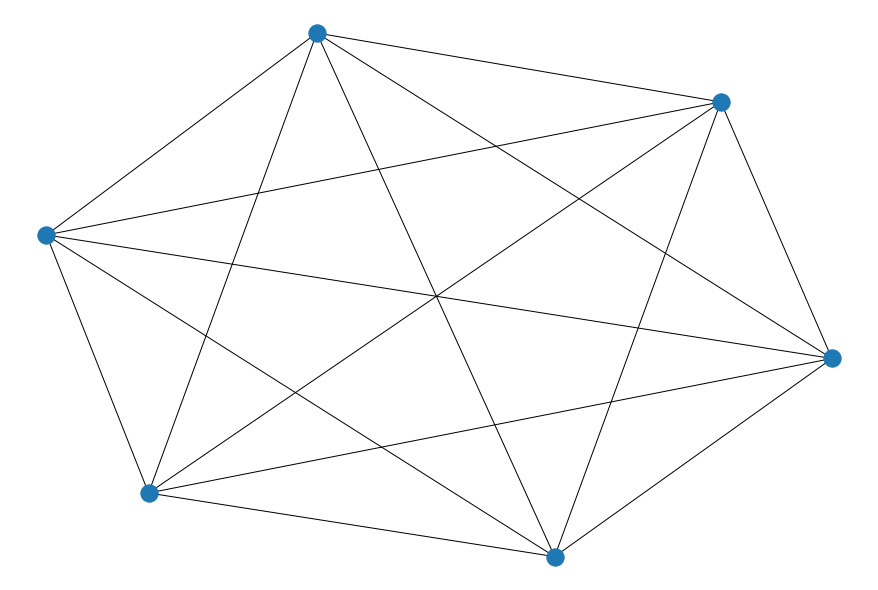

In [161]:
pos = nx.circular_layout(G)
nx.draw(G)